In [ ]:
!pip install wordcloud
!pip install - U spacy


In [1]:
import csv

#data manipulation
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#text packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import spacy
from bs4 import BeautifulSoup

#model preparation & selection
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")


# Import data

In [105]:
name = "movies.csv"
text_data = pd.read_csv(name, header=0)
text_data.columns = ["name", "comment", "label"]
print(text_data.shape)
text_data = text_data.dropna(axis=0, how='any', inplace=False)
text_data = text_data.astype(str)
text_data.head(), print(text_data.shape)


(14050, 3)
(13735, 3)


(      name                                            comment   label
 0  juniper  Filmmakers should showcase Rampling’s indomita...  rotten
 1  juniper  Savilles directorial debut is solid just like ...   fresh
 2  juniper  It feels personal in a lot of the details and ...   fresh
 3  juniper  We've seen this a million times -- but not wit...   fresh
 4  juniper  Juniper takes some time to get where it is goi...   fresh,
 None)

# Process data

In [54]:
contractions = {
    "aight": "alright",
    "ain't": "am not",
    "amn't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "daren't": "dare not",
    "daresn't": "dare not",
    "dasn't": "dare not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "d'ye": "do you",
    "e'er": "ever",
    "everybody's": "everybody is",
    "everyone's": "everyone is",
    "finna": "fixing to",
    "g'day": "good day",
    "gimme": "give me",
    "giv'n": "given",
    "gonna": "going to",
    "gon't": "go not",
    "gotta": "got to",
    "hadn't": "had not",
    "had've": "had have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'dn't've'd": "he would not have had",
    "he'll": "he will",
    "he's": "he is",
    "he've": "he have",
    "how'd": "how would",
    "howdy": "how do you do",
    "how'll": "how will",
    "how're": "how are",
    "I'll": "I will",
    "I'm": "I am",
    "I'm'a": "I am about to",
    "I'm'o": "I am going to",
    "innit": "is it not",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "may've": "may have",
    "methinks": "me thinks",
    "mightn't": "might not",
    "might've": "might have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "must've": "must have",
    "needn't": "need not",
    "ne'er": "never",
    "o'clock": "of the clock",
    "o'er": "over",
    "ol'": "old",
    "oughtn't": "ought not",
    "'s": "is",
    "shalln't": "shall not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she shall",
    "she'll": "she will",
    "she's": "she has",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "somebody's": "somebody has",
    "somebody's": "somebody is",
    "someone's": "someone has",
    "someone's": "someone is",
    "something's": "something has",
    "something's": "something is",
    "so're": "so are",
    "that'll": "that shall",
    "that'll": "that will",
    "that're": "that are",
    "that's": "that has",
    "that's": "that is",
    "that'd": "that would",
    "that'd": "that had",
    "there'd": "there had",
    "there'd": "there would",
    "there'll": "there shall",
    "there'll": "there will",
    "there're": "there are",
    "there's": "there has",
    "there's": "there is",
    "these're": "these are",
    "these've": "these have",
    "they'd": "they had",
    "they'd": "they would",
    "they'll": "they shall",
    "they'll": "they will",
    "they're": "they are",
    "they're": "they were",
    "they've": "they have",
    "this's": "this has",
    "this's": "this is",
    "those're": "those are",
    "those've": "those have",
    "'tis": "it is",
    "to've": "to have",
    "'twas": "it was",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd": "we would",
    "we'd": "we did",
    "we'll": "we shall",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'd": "what did",
    "what'll": "what shall",
    "what'll": "what will",
    "what're": "what are",
    "what're": "what were",
    "what's": "what has",
    "what's": "what is",
    "what's": "what does",
    "what've": "what have",
    "when's": "when has",
    "when's": "when is",
    "where'd": "where did",
    "where'll": "where shall",
    "where'll": "where will",
    "where're": "where are",
    "where's": "where has",
    "where's": "where is",
    "where's": "where does",
    "where've": "where have",
    "which'd": "which had",
    "which'd": "which would",
    "which'll": "which shall",
    "which'll": "which will",
    "which're": "which are",
    "which's": "which has",
    "which's": "which is",
    "which've": "which have",
    "who'd": "who would",
    "who'd": "who had",
    "who'd": "who did",
    "who'd've": "who would have",
    "who'll": "who shall",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who has",
    "who's": "who is",
    "who's": "who does",
    "who've": "who have",
    "why'd": "why did",
    "why're": "why are",
    "why's": "why has",
    "why's": "why is",
    "why's": "why does",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd've": "you all would have",
    "y'all'dn't've'd": "you all would not have had",
    "y'all're": "you all are",
    "you'd": "you had",
    "you'd": "you would",
    "you'll": "you shall",
    "you'll": "you will",
    "you're": "you are",
    "you're": "you are",
    "you've": "you have",
    " u ": "you",
    " ur ": "your",
    " n ": "and"
}


def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x


In [97]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')


def preprocess_text(df):
    df['comment'] = df['comment'].apply(lambda x: x.lower())

    df['comment'] = df['comment'].apply(lambda x: cont_to_exp(x))

    # Remove HTML
    df['comment'] = df['comment'].apply(
        lambda x: BeautifulSoup(x, 'lxml').get_text())
    
    # Remove Emails
    df['comment'] = df['comment'].apply(lambda x: re.sub(
        r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', x))

    # # Remove urls
    df['comment'] = df['comment'].apply(lambda x: re.sub(
        r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x))
    
    # Create a spaCy Doc object
    df['comment'] = df['comment'].apply(lambda x: ' '.join(
        [t for t in x.split() if t not in STOP_WORDS]))
    
    # Removal of special chars and punctuation
    df['comment'] = df['comment'].apply(
        lambda x: re.sub('[^\w]', ' ', x))
    
    # Removing multiple spaces
    df['comment'] = df['comment'].apply(lambda x: ' '.join(x.split()))
    
    return df


# Example usage
data = {'comment': [
    "We've this! An -- example <b>text</b> with an email@example.com and some punctuation!!!"]}
test = pd.DataFrame(data)

df = preprocess_text(text_data)
print(df)  # Output: "example text email punctuation"


          name                                            comment   label
0      juniper  filmmakers showcase rampling s indomitable pre...  rotten
1      juniper  savilles directorial debut solid like script g...   fresh
2      juniper  feels personal lot details production design e...   fresh
3      juniper  seen million times charlotte rampling elevates...   fresh
4      juniper  juniper takes time going invested odd couple f...   fresh
...        ...                                                ...     ...
14043    delta  tide political correctness delta chart unsafe ...   fresh
14044    delta  film infuential prescient ever signature work ...   fresh
14045    delta  sachs sustain cinematic promise deltais early ...   fresh
14046    delta  intimate gay drama complex relationship white ...  rotten
14049   damien  compelling drama suffering servanthood ministr...   fresh

[13735 rows x 3 columns]


# Explore data before training

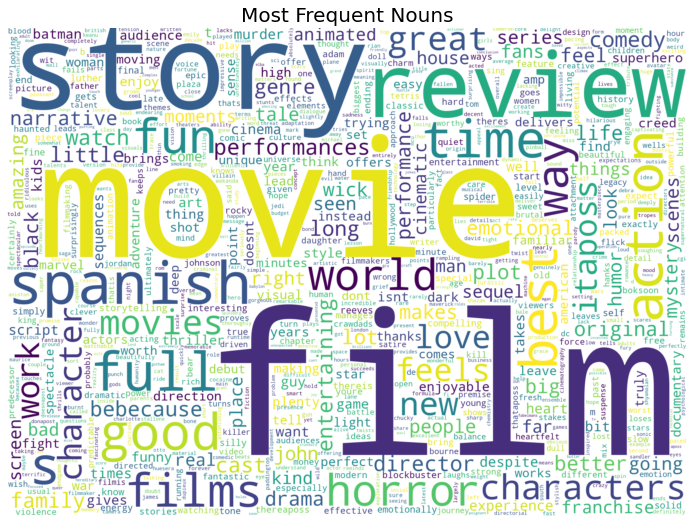

In [98]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline
text = ' '.join(df['comment'])
text = text.split()
x = ' '.join(text[:20000])
wordcloud_noun = WordCloud(width=2500, height=1800,
                           max_words=800,
                           background_color='white', collocations=False,
                           normalize_plurals=False).generate(x)
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud_noun, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Nouns', fontsize=20)
plt.show()


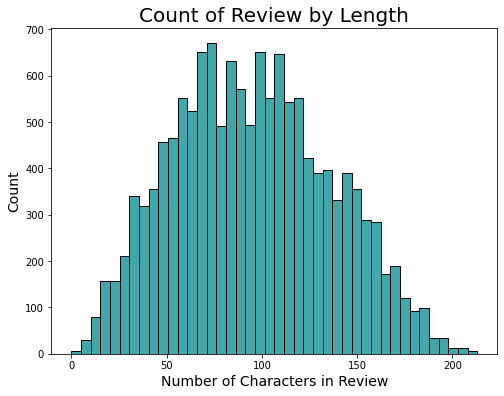

In [99]:
new_data_df = text_data.copy()

new_data_df['Text_Length'] = new_data_df['comment'].str.len()

plt.figure(figsize=(8, 6))
ax = sns.histplot(x=new_data_df['Text_Length'], color='darkcyan')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Number of Characters in Review', fontsize=14)
plt.title('Count of Review by Length', fontsize=20)
plt.show()


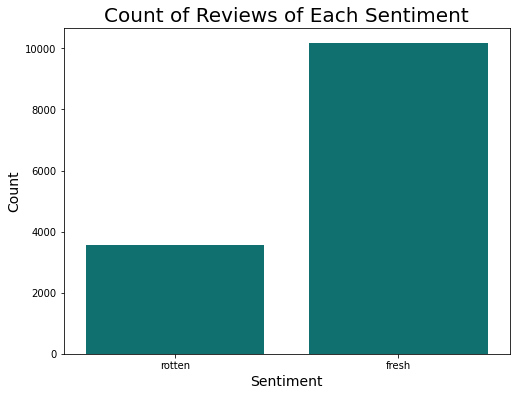

In [100]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=new_data_df['label'], color='teal')
#plt.xlim(0,12000)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Sentiment', fontsize=14)
plt.title('Count of Reviews of Each Sentiment', fontsize=20)
plt.show()


In [101]:
print('There are '+ str(text_data[text_data['label']=='fresh'].shape[0])+' positive reviews.')
print('There are '+ str(text_data[text_data['label']!='fresh'].shape[0]) + ' negative reviews.')

There are 10169 positive reviews.
There are 3566 negative reviews.


# Train SVM

In [102]:
labels = "fresh"
vec = TfidfVectorizer(stop_words='english', min_df=7,
                      ngram_range=(1, 2), max_df=0.8)
X_data = vec.fit_transform(df['comment'])
df['sentiment_score'] = np.where(
    df['label'] == labels, 1, 0)
Y_data = df['sentiment_score']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X_data, Y_data, test_size=0.15, random_state=0)

#Support Vector Machine (not cross-validating here)
clf = SVC(kernel='rbf', probability=True).fit(Xtrain, Ytrain)
clf_score = clf.score(Xtest, Ytest)


# # Train the SVM classifier
# classifier = SVC(kernel='linear')
# classifier.fit(vectorized_sentences, labels)


In [103]:
print('The accuracy for the kernel SVC model is '+str(clf_score))
clf_f1score = f1_score(Ytest, clf.predict(Xtest))
print('The F1 for the kernel SVC model is '+str(clf_f1score))


The accuracy for the kernel SVC model is 0.9199417758369723
The F1 for the kernel SVC model is 0.9491211840888066


In [106]:
import joblib
joblib.dump(clf, "%s.pkl" % name.split(".")[0])
joblib.dump(vec, "%s.pkl" % name.split(".")[0]+"_vec")


['movies.pkl_vec']

In [107]:
estimator = joblib.load("%s.pkl" % name.split(".")[0])
pkl_vec = joblib.load("%s.pkl" % name.split(".")[0]+"_vec")
# Test on a new sentence


def test(clf, vec, text):
    test_vectorized_sentence = vec.transform([text])
    prediction = clf.predict(test_vectorized_sentence)
    # Output: [1] (positive sentiment)
    print(prediction, clf.predict_proba(
        test_vectorized_sentence)[0][prediction[0]])


test(estimator, pkl_vec, "This movie is shit")


[0] 0.9987377058514942
